In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi
import os
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
from PIL import Image
import urllib, cStringIO
import cv2
from tensorflow.contrib import layers

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 64


In [3]:
attr_file = '../data/celeba/list_attr_celeba.txt'
keys = None
attributes_by_image = {}
for i, line in enumerate(open(attr_file)):
    if i == 1:
        keys = line.split()
    elif i > 1:
        image = os.path.join('../data/celeba/img_align_celeba', line.split()[0])
        values = line.split()[1:]
        attributes_by_image[image] = {attr: val == '1' for attr, val in zip(keys, values)}


In [4]:
image_names = attributes_by_image.keys()
attr_vector = np.zeros((len(attributes_by_image), len(keys)))
for i, image_name in enumerate(image_names):
    attrs = attributes_by_image[image_name]
    attr_vector[i] = [(1 if attrs[key] else 0) for key in keys]


In [5]:
# filename_queue = tf.train.string_input_producer(image_names, num_epochs=None)
# attr_queue = tf.train.input_producer(tf.constant(attr_vector), num_epochs=None)

def create_qs(train):
    filename_tensor = tf.convert_to_tensor(image_names, dtype=tf.string)
    attr_tensor = tf.convert_to_tensor(attr_vector, dtype=tf.float32)
    filename_q, attr_q = tf.train.slice_input_producer([filename_tensor, attr_tensor], num_epochs=None, shuffle=True)

    # reader = tf.WholeFileReader()
    # filename, image_data = reader.read(filename_q)
    image_255 = tf.image.decode_jpeg(tf.read_file(filename_q))
    image = tf.reshape(tf.cast(image_255, tf.float32) / 255.0, [218, 178, 3]) # images are 178x218
    # image = tf.image.rgb_to_grayscale(image)

    def resize_image(image):
        # image = tf.random_crop(image, [192, 160, 3])
        # return image
        image = tf.image.resize_image_with_crop_or_pad(image, 160, 160)
        img_reshaped = tf.reshape(image, [1, 160, 160, 3])
        image = tf.image.resize_bilinear(img_reshaped, [IMAGE_SIZE, IMAGE_SIZE])
        return tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE, 3])
    image = resize_image(image)

    def distort_image(image):
        # noise_amt = tf.abs(tf.random_normal([], stddev=0.2))
        # distorted_image = image + tf.random_uniform([64, 64, 3], maxval=noise_amt)
        distorted_image = tf.image.random_flip_left_right(image)
        distorted_image = tf.image.random_brightness(distorted_image, max_delta=0.3)
        distorted_image = tf.image.random_contrast(distorted_image, lower=0.6, upper=1.6)
        # distorted_image = tf.image.per_image_standardization(distorted_image)
        # distorted_image = tf.clip_by_value(distorted_image, 0, 1)
        return distorted_image

    images_batch, attrs_batch = tf.train.shuffle_batch([distort_image(image), attr_q], batch_size=BATCH_SIZE, capacity=BATCH_SIZE*20, min_after_dequeue=BATCH_SIZE*10)
    return images_batch, attrs_batch

images_batch, attrs_batch = create_qs(True)


In [6]:
session = tf.InteractiveSession()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
tf.train.start_queue_runners(sess=session)

[<Thread(Thread-13, started daemon 140453977655040)>,
 <Thread(Thread-14, started daemon 140453969262336)>]

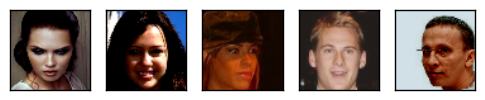

In [7]:
images_, attrs_ = session.run([images_batch, attrs_batch])

imshow_multi(images_[:5])

In [8]:
keys

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [9]:
def lrelu(x):
    # leaky relu
    alpha = 0.1
    return tf.maximum(alpha*x,x)

def identity(x): return x


In [16]:
gen_conv_init = tf.truncated_normal_initializer(0.0, 0.02)
disc_conv_init = tf.truncated_normal_initializer(0.0, 0.02)
biases_initializer = tf.truncated_normal_initializer(0.02, 0.0)

def generator(noise_vec, condition_vec, name='gen', reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        vec = tf.concat([noise_vec, tf.cast(condition_vec, tf.float32)], 1)
        image = tf.reshape(vec, [-1, 1, 1, vec.get_shape()[-1].value])
        n_layers = 6
        for i in xrange(n_layers):
            n_channels = min(256, 32 * 2 ** (n_layers - i - 1))
            image = layers.conv2d_transpose(image, 
                                n_channels, 
                                scope='gen_'+str(i), 
                                kernel_size=2, 
                                activation_fn=lrelu, 
                                normalizer_fn=layers.batch_norm,
                                stride=2,
                                weights_initializer=gen_conv_init)
        return layers.conv2d(image, 
                             3, 
                             scope='color', 
                             kernel_size=1, 
                             activation_fn=tf.tanh, 
                             biases_initializer=biases_initializer)

def disc(image, cond_vec, name='disc', reuse=False):
    orig_image = image
    conv_vec_float = tf.reshape(tf.cast(cond_vec, tf.float32), [1, 1, 1, -1])
    with tf.variable_scope(name, reuse=reuse):
        for i in xrange(5):
            n_channels = min(256, 32 * 2 ** i)
            norm = layers.batch_norm if i > 0 else None
            image = layers.conv2d(image,
                      n_channels, 
                      scope='disc_'+str(i), 
                      kernel_size=5, 
                      activation_fn=lrelu, 
                      stride=2,
                      normalizer_fn=norm, 
                      #  biases_initializer=biases_initializer,
                      weights_initializer=disc_conv_init)
            # concat the condition vec:
            b, h, w, _ = [dim.value for dim in image.get_shape()]
            tiling = tf.stack([b,h,w,1])
            conv_vec_resized = tf.tile(conv_vec_float, tiling)
            # concat the resized image:
            resized = tf.image.resize_images(orig_image, [h, w])
            
            image = tf.concat([image, conv_vec_resized, resized], axis=3)
        fc1 = layers.flatten(image)
        fc1 = layers.fully_connected(fc1, 128, activation_fn=lrelu, scope='fc1', biases_initializer=biases_initializer)
        fc2 = layers.fully_connected(fc1, 1, scope='fc2', activation_fn=identity)
        return tf.reshape(fc2, [-1])

def l2_loss(y, y_):
    return tf.reduce_mean((y - y_) ** 2)

def l2_reg(vars):
    def l2(v): return tf.reduce_mean(v ** 2)
    return tf.add_n([l2(v) for v in vars]) / len(vars)
    
scopename = 'gan3'
with tf.variable_scope(scopename, reuse=False):
    gen_lr = tf.placeholder_with_default(tf.constant(5e-2), [], name='gen_lr')
    disc_lr = tf.placeholder_with_default(tf.constant(5e-2), [], name='disc_r')
    
    attributes = ['Male', 'Smiling']
    attr_indices = [keys.index(attr) for attr in attributes]
    real_cond_vec = tf.transpose(tf.gather(tf.transpose(attrs_batch, [1, 0]), attr_indices), [1, 0])
    real_cond_vec = tf.cast(real_cond_vec, tf.int32)
        
    fake_cond_vec_target = tf.random_uniform([BATCH_SIZE, len(attributes)], minval=0, maxval=2, dtype=tf.int32)
    noise = tf.random_normal([BATCH_SIZE, 128])
    generated_images = generator(noise, fake_cond_vec_target)
    
    are_fakes_real = disc(generated_images, fake_cond_vec_target)
    are_reals_real = disc(images_batch, real_cond_vec)
    
    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/gen')
    gen_loss = tf.reduce_mean(-are_fakes_real) # maximize this
    gen_loss += l2_reg(gen_vars) * 0.001
    
    disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/disc')
    disc_loss = tf.reduce_mean(are_fakes_real - are_reals_real)
    # disc_loss += l2_reg(disc_vars) * 0.001
        
    # only increment the global step when training the generator:
    global_step = tf.contrib.framework.get_or_create_global_step()
    
    train_disc_op = tf.train.RMSPropOptimizer(disc_lr).minimize(disc_loss, var_list=disc_vars)
    weight_clip_op = tf.group(*[w.assign(tf.clip_by_value(w, -0.01, 0.01)) for w in disc_vars])
    train_disc = tf.group(weight_clip_op, train_disc_op)
    # train_disc = train_disc_op
    
    train_gen_op = tf.train.AdamOptimizer(gen_lr).minimize(gen_loss, global_step=global_step, var_list=gen_vars)
    # weight_clip_op = tf.group(*[w.assign(tf.clip_by_value(w, -1, 1)) for w in gen_vars])
    # train_gen = tf.group(weight_clip_op, train_gen_op)
    train_gen = train_gen_op
    
    examples = generated_images

print 'ok'

ok


In [17]:
session = None
saver = None
save_path = None

def create_session():
    global session
    global saver
    global save_path
    
    if session: session.close()
    
    session = tf.InteractiveSession()

    save_path = None # 'models/lsgan-face-cond-1'
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    session.run(init_op)
    tf.train.start_queue_runners(sess=session)

    import os
    saver = None
    if save_path:
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(save_path)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(session, ckpt.model_checkpoint_path)
            print 'Restored from checkpoint', ckpt.model_checkpoint_path
        else:
            print 'Did not restore from checkpoint'
    else:
        print 'Will not save progress'

create_session()

Will not save progress


Step: 0, disc loss: 0.0124756228179, gen loss: 0.00841436162591


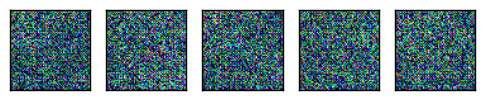

Step: 60, disc loss: -0.104763418296, gen loss: 0.0852089797826


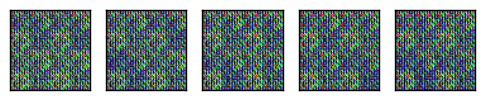

Step: 120, disc loss: -3.2047665637, gen loss: 1.88612247606


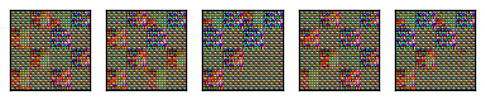

Step: 180, disc loss: -6.58389274428, gen loss: 3.41030717542


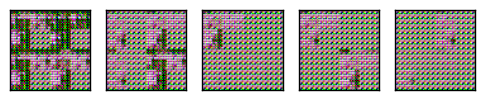

Step: 240, disc loss: -7.02473770777, gen loss: 3.75533491994


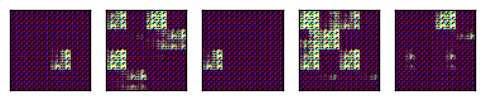

Step: 300, disc loss: -7.54189567566, gen loss: 4.00727240245


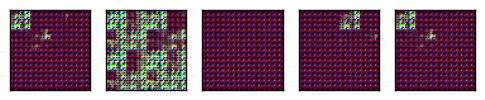

Step: 360, disc loss: -7.54314231823, gen loss: 3.96707615852


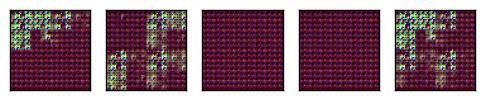

Step: 420, disc loss: -7.57785414755, gen loss: 4.0942042311


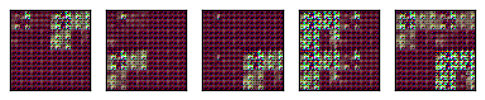

Step: 480, disc loss: -6.73159256255, gen loss: 3.70417699503


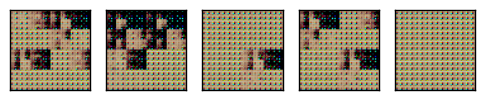

Step: 540, disc loss: -7.28145618749, gen loss: 3.87513605754


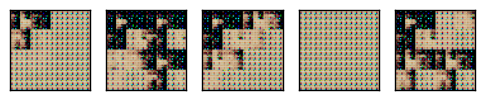

Step: 600, disc loss: -6.89388038913, gen loss: 3.69894086607


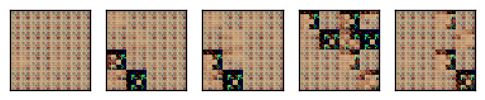

Step: 660, disc loss: -7.53233552774, gen loss: 4.04257917007


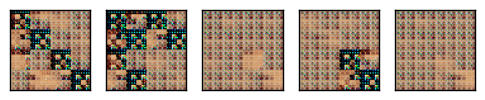

Step: 720, disc loss: -7.5189174811, gen loss: 3.99820775787


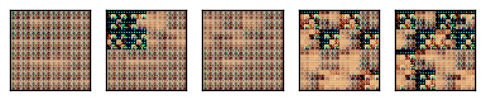

Step: 780, disc loss: -7.47174302563, gen loss: 4.0377675275


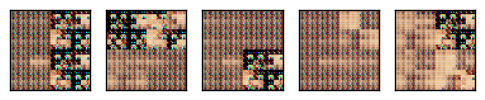

Step: 840, disc loss: -6.99562865222, gen loss: 3.81869684532


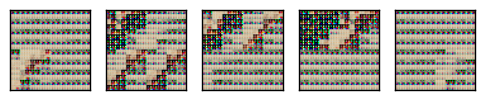

Step: 900, disc loss: -7.2612316524, gen loss: 3.71709519227


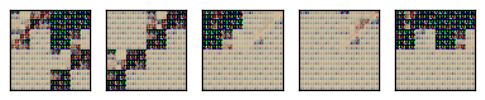

KeyboardInterrupt: 

In [18]:
def avg(x): return sum(x) / float(len(x))

savecount = 0

last_step_printed = -1

gen_losses = []
disc_losses = []

while True:
    examples_ = None
    step_ = global_step.eval()
    
    feed = {
        gen_lr: 0.001,
        disc_lr: 0.001
    }
    _, _, gen_loss_, disc_loss_ = session.run([train_gen, train_disc, gen_loss, disc_loss], feed_dict=feed)
    gen_losses.append(gen_loss_)
    disc_losses.append(disc_loss_)
    
    if step_ % 60 == 0:
        print "Step: {}, disc loss: {}, gen loss: {}".format(step_, avg(disc_losses), avg(gen_losses))
        disc_losses = []
        gen_losses = []
        
        if step_ % 60 == 0:
            examples_ = session.run(examples[:5])
            imshow_multi(list(examples_))
        
        if step_ % 2000 == 0 and saver:
            should_save = True
            if should_save:
                saver.save(session, save_path + '/model.ckpt', global_step=step_)
                print 'Saved'
                savecount += 1
                if savecount > 4:
                    create_session()
                    savecount = 0


In [ ]:
# debug:

fake_cond_vec_, real_cond_vec_, _ = session.run([fake_cond_vec, real_cond_vec, images_batch])
print fake_cond_vec_
print real_cond_vec_

In [ ]:
%matplotlib inline

examples_ = session.run(examples[:5])
imshow_multi(list(examples_))
